In [ ]:
import numpy as np
import pandas as pd
import QuantLib as ql
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing, linear_model
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
import time

import optuna
import seaborn as sns
import matplotlib.pyplot as plt

# Random seed for reproducibility
np.random.seed(42)

# Import Data

In [3]:
heston_simulated = pd.read_parquet('heston_simulated_price_preprocessed_feller_bound.pq').sample(50000).reset_index().iloc[:,1:11]
heston_simulated

,moneyness,Time to maturity,interest rate,divident yield,initial vol,long term expected vol,vol revert rate,vol of vol,correlation of W and W,Call Option Price
0,0.808343,93.04,0.055580,0.0153,0.230737,0.967624,0.278500,0.000005,0.017913,0.806566
1,0.835896,99.00,0.047630,0.0166,0.199566,0.466418,0.615062,0.000004,0.030243,0.769226
2,0.973242,42.00,0.044120,0.0171,0.148507,0.809239,0.833325,0.000005,0.030402,0.817337
3,0.854640,100.96,0.047433,0.0171,0.173142,0.538232,0.889304,0.000006,0.050611,0.775977
4,1.018684,71.04,0.055490,0.0156,0.190773,1.999906,0.826702,0.000004,0.033848,0.810449
...,...,...,...,...,...,...,...,...,...,...
49995,0.995855,18.00,0.055400,0.0156,0.180665,0.346238,0.058064,0.000036,0.011347,0.657953
49996,1.011446,22.00,0.054600,0.0158,0.152451,1.999641,0.892851,0.000015,0.017091,0.881268
49997,0.979299,108.96,0.047440,0.0171,0.152451,0.245269,0.867167,0.000031,0.027108,0.696061
49998,0.653147,28.96,0.047500,0.0166,0.180665,1.999863,0.850837,0.000015,0.014458,0.877330


## Standarlize and use train_test_split with 80% for training and 20% for test

In [4]:
df = heston_simulated.copy()

scaler = preprocessing.StandardScaler()

X = scaler.fit_transform(df.iloc[:,:-1])
y = df['Call Option Price']

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

y_test

27632    0.411477
36119    0.798913
4796     0.826706
3648     0.746467
24501    0.791758
           ...   
39432    0.914365
9566     0.783263
8894     0.740031
39283    0.870712
18187    0.708004
Name: Call Option Price, Length: 10000, dtype: float64

# Class: ModelTrainer

In [ ]:
class ModelTrainer:
    def __init__(self, model, param_space, X_train, y_train):
        """
        Initialize the ModelTrainer class.

        Parameters:
        - model: The model class (e.g., RandomForestRegressor).
        - param_space: A function that defines the hyperparameter search space for Optuna.
        - X_train: Training features.
        - y_train: Training labels.
        """
        self.model = model
        self.param_space = param_space
        self.X_train = X_train
        self.y_train = y_train
        self.best_params = None
        self.trained_model = None

    def optimize(self, n_trials=10):
        """
        Optimize hyperparameters using Optuna.

        Parameters:
        - n_trials: Number of trials for Optuna optimization.
        """
        def objective(trial):
            # Define hyperparameter space using the provided function
            params = self.param_space(trial)
            # Initialize the model with sampled parameters
            model_instance = self.model(**params)
            # Cross-validation to evaluate performance
            score = cross_val_score(model_instance, self.X_train, self.y_train, cv=5, 
                                     scoring='neg_mean_squared_error', n_jobs=-1)
            rmse = (-score.mean())**0.5  # Convert negative MSE to RMSE
            return rmse

        # Run Optuna optimization
        optuna.logging.set_verbosity(optuna.logging.INFO)  # Enable progress logging
        start_time = time.time()
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
        optuna_time = time.time() - start_time

        # Save best parameters
        self.best_params = study.best_params

        print("\nBest Hyperparameters from Optuna:")
        print(self.best_params)
        print(f"Optuna Optimization Time: {optuna_time:.4f} seconds")

    def predict(self, X_test):
        """
        Train the model with the best parameters and make predictions.

        Parameters:
        - X_test: Test features for prediction.

        Returns:
        - y_pred: Predictions for the test set.
        """
        print("\nTraining the model with the best parameters...")
        self.trained_model = self.model(**self.best_params)
        start_time = time.time()
        self.trained_model.fit(self.X_train, self.y_train)
        train_time = time.time() - start_time
        print(f"Training Time: {train_time:.4f} seconds")

        # Predict on test set
        return self.trained_model.predict(X_test)

    def result_evaluation(self, X_test, y_test, y_pred, heston_simulated, percentile_boundary=99):
        """
        Evaluate the prediction results with error analysis and visualization.

        Parameters:
        - X_test: Test features.
        - y_test: Actual target values for the test set.
        - y_pred: Predicted target values.
        - heston_simulated: Dataframe containing the original simulated data.
        - percentile_boundary: Threshold for large error analysis (default is 99th percentile).
        """
        # Create a DataFrame to store actual and predicted values
        df_pred = pd.DataFrame(X_test, columns=heston_simulated.columns[:X_test.shape[1]])
        df_pred['Actual Price'] = y_test
        df_pred['Predicted Price'] = y_pred

        # Calculate prediction errors and identify large errors
        errors = np.abs(df_pred['Actual Price'] - df_pred['Predicted Price'])
        threshold = np.percentile(errors, percentile_boundary)
        large_error_indices = np.where(errors > threshold)[0]

        # Plot prediction errors with threshold
        plt.figure(figsize=(10, 6))
        plt.plot(errors, 'o', color='purple', alpha=0.7)
        plt.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold = {threshold:.4f}')
        plt.xlabel('Test Sample Index')
        plt.ylabel('Prediction Error')
        plt.title('Prediction Error Distribution')
        plt.legend()
        plt.grid()
        plt.show()

        # Scatter plot of actual vs predicted values
        plt.figure(figsize=(10, 6))
        plt.scatter(df_pred['Actual Price'], df_pred['Predicted Price'], color='blue', alpha=0.6, label='All Points')
        plt.scatter(df_pred.iloc[large_error_indices]['Actual Price'], df_pred.iloc[large_error_indices]['Predicted Price'], 
                    color='red', alpha=0.8, label='Large Error Points')
        plt.plot([df_pred['Actual Price'].min(), df_pred['Actual Price'].max()],
                 [df_pred['Actual Price'].min(), df_pred['Actual Price'].max()],
                 color='green', linestyle='--', linewidth=1, label='y = x')
        plt.xlabel('Actual Price')
        plt.ylabel('Predicted Price')
        plt.title('Actual vs Predicted Prices')
        plt.legend()
        plt.grid()
        plt.show()

        # Analyze large error data
        large_error_data = heston_simulated.iloc[large_error_indices]
        large_error_mean = large_error_data.mean()
        all_data_mean = heston_simulated.mean()

        print("\nFeature Means Comparison:")
        print(pd.DataFrame({
            'All Data Mean': all_data_mean,
            'Large Error Data Mean': large_error_mean
        }))

        # Plot KDE for feature comparison
        features = heston_simulated.columns[:10]  # Use the first 10 features for comparison
        plt.figure(figsize=(15, 10))
        for feature in features:
            sns.kdeplot(heston_simulated[feature], label='All Data', color='blue', alpha=0.5)
            sns.kdeplot(large_error_data[feature], label='Large Error Data', color='red', alpha=0.5)
            plt.title(f'Feature Distribution: {feature}')
            plt.xlabel(feature)
            plt.ylabel('Density')
            plt.legend()
            plt.grid()
            plt.show()

        # Correlation of features with prediction error
        correlations = heston_simulated.corrwith(pd.Series(errors, index=df_pred.index))
        print("\nCorrelation with Prediction Error:")
        print(correlations)


# Now we can start training and tuning models!

## Tune Random Forest with Optuna (hyperparameters: max_depth, n_estimators, max_features) 

[I 2024-12-09 21:03:31,044] A new study created in memory with name: no-name-a28089e1-09a3-4771-8e81-072031ea5d24


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-12-09 21:05:17,478] Trial 0 finished with value: 0.016908070513797863 and parameters: {'n_estimators': 358, 'max_depth': 22, 'max_features': None}. Best is trial 0 with value: 0.016908070513797863.
[I 2024-12-09 21:07:31,072] Trial 1 finished with value: 0.019186867488208876 and parameters: {'n_estimators': 716, 'max_depth': 11, 'max_features': None}. Best is trial 0 with value: 0.016908070513797863.
[I 2024-12-09 21:09:15,754] Trial 2 finished with value: 0.019390316135167535 and parameters: {'n_estimators': 656, 'max_depth': 29, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.016908070513797863.
[I 2024-12-09 21:10:47,546] Trial 3 finished with value: 0.020184511708115343 and parameters: {'n_estimators': 791, 'max_depth': 15, 'max_features': 'log2'}. Best is trial 0 with value: 0.016908070513797863.
[I 2024-12-09 21:12:01,522] Trial 4 finished with value: 0.01935172857161961 and parameters: {'n_estimators': 439, 'max_depth': 30, 'max_features': 'sqrt'}. Best is trial 0

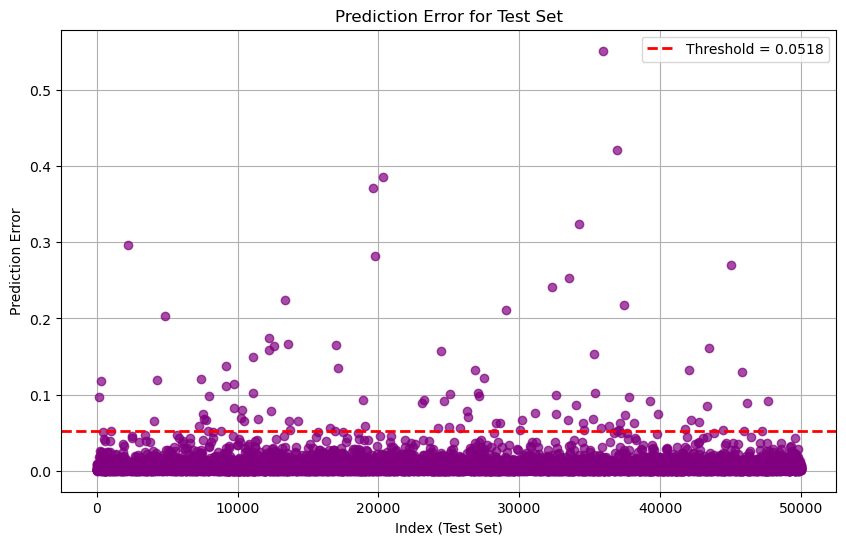

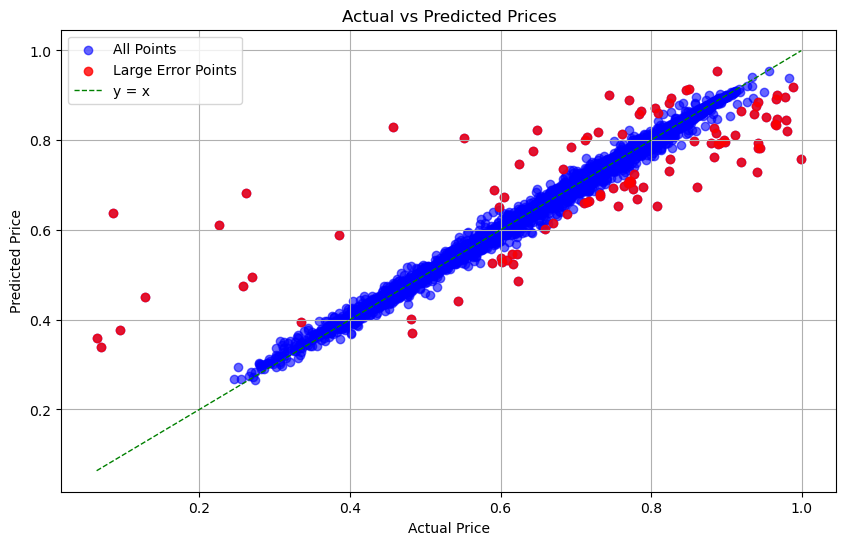

Feature Means Comparison:
                        All Data Mean  Large Error Data Mean
moneyness                    0.905414               0.857793
Time to maturity            44.927257              87.926800
interest rate                0.050728               0.051322
divident yield               0.016384               0.016430
initial vol                  0.212124               0.304721
long term expected vol       0.969919               1.214971
vol revert rate              0.549986               0.398727
vol of vol                   0.000172               0.000203
correlation of W and W       0.021241               0.020392
Call Option Price            0.747589               0.719380


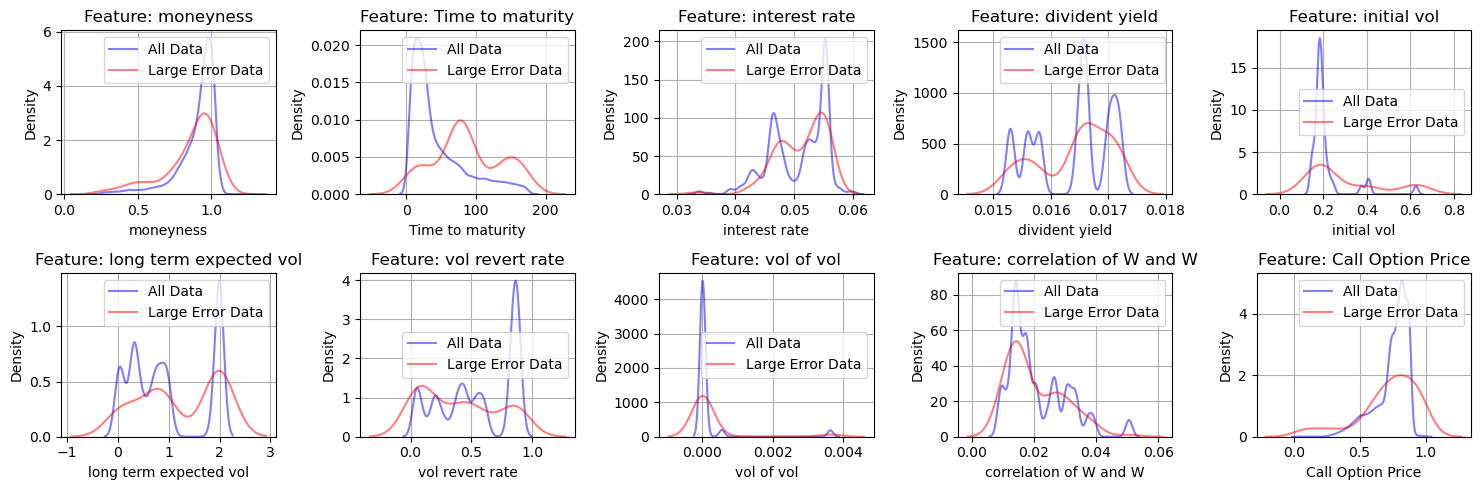

Correlation with Prediction Error:
moneyness                -0.069678
Time to maturity          0.077895
interest rate            -0.006943
divident yield            0.015443
initial vol               0.110958
long term expected vol   -0.071778
vol revert rate          -0.113618
vol of vol                0.009800
correlation of W and W   -0.001067
Call Option Price        -0.232197
dtype: float64


In [7]:
# Define hyperparameter search space
def random_forest_param_space(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 10
    }

# Example Usage
from sklearn.ensemble import RandomForestRegressor

# Initialize the trainer
trainer = ModelTrainer(RandomForestRegressor, random_forest_param_space, X_train, y_train)

# Optimize hyperparameters
trainer.optimize(n_trials=10)

# Train and make predictions
rf_y_pred = trainer.predict(X_test)

# Evaluate results
trainer.result_evaluation(X_test, y_test, rf_y_pred)


## Tune the Gradient Boost Regressor with Optuna (hyperparameters: max_depth, n_estimators, max_features)  

[I 2024-12-09 21:20:16,205] A new study created in memory with name: no-name-9147e38a-a3b4-415c-a12a-548d1d11d7a4


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-12-09 21:23:50,007] Trial 0 finished with value: 0.01707366053469133 and parameters: {'n_estimators': 1900, 'max_depth': 4, 'learning_rate': 0.02639229116722792}. Best is trial 0 with value: 0.01707366053469133.
[I 2024-12-09 21:26:08,097] Trial 1 finished with value: 0.017534957994978492 and parameters: {'n_estimators': 1700, 'max_depth': 3, 'learning_rate': 0.15731029554479503}. Best is trial 0 with value: 0.01707366053469133.
[I 2024-12-09 21:27:30,864] Trial 2 finished with value: 0.02724365587405771 and parameters: {'n_estimators': 1300, 'max_depth': 2, 'learning_rate': 0.0454485925006765}. Best is trial 0 with value: 0.01707366053469133.
[I 2024-12-09 21:31:04,559] Trial 3 finished with value: 0.015179005029691654 and parameters: {'n_estimators': 1500, 'max_depth': 5, 'learning_rate': 0.1848233755925162}. Best is trial 3 with value: 0.015179005029691654.
[I 2024-12-09 21:34:45,959] Trial 4 finished with value: 0.015048104597308022 and parameters: {'n_estimators': 1700, 'm

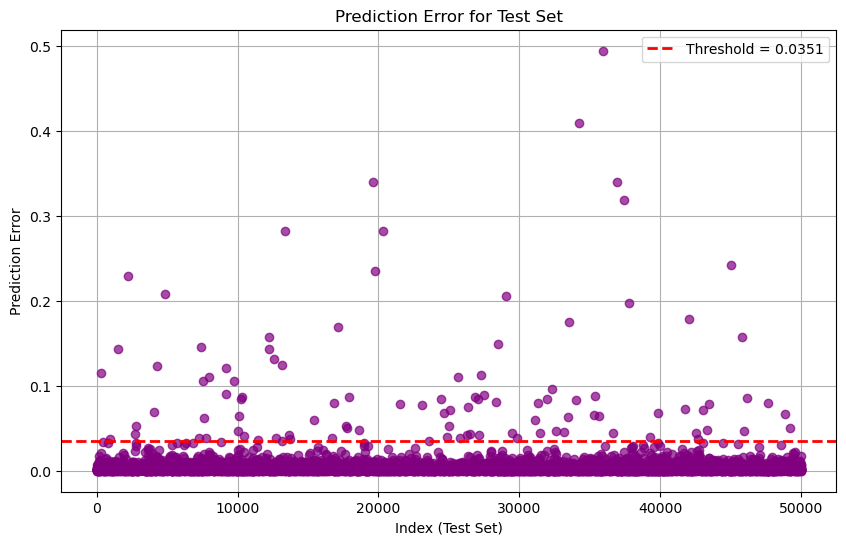

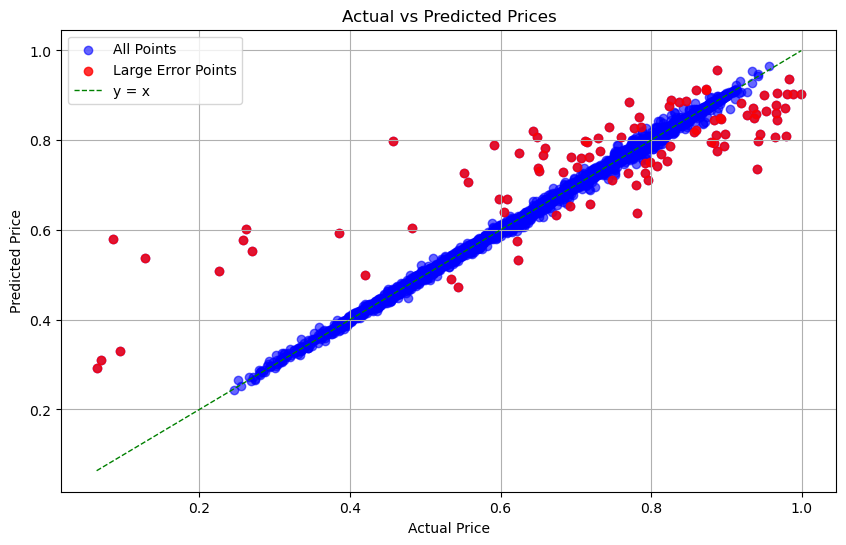

Feature Means Comparison:
                        All Data Mean  Large Error Data Mean
moneyness                    0.905414               0.867343
Time to maturity            44.927257             102.747600
interest rate                0.050728               0.051739
divident yield               0.016384               0.016448
initial vol                  0.212124               0.241093
long term expected vol       0.969919               1.460421
vol revert rate              0.549986               0.497905
vol of vol                   0.000172               0.000282
correlation of W and W       0.021241               0.020035
Call Option Price            0.747589               0.728593


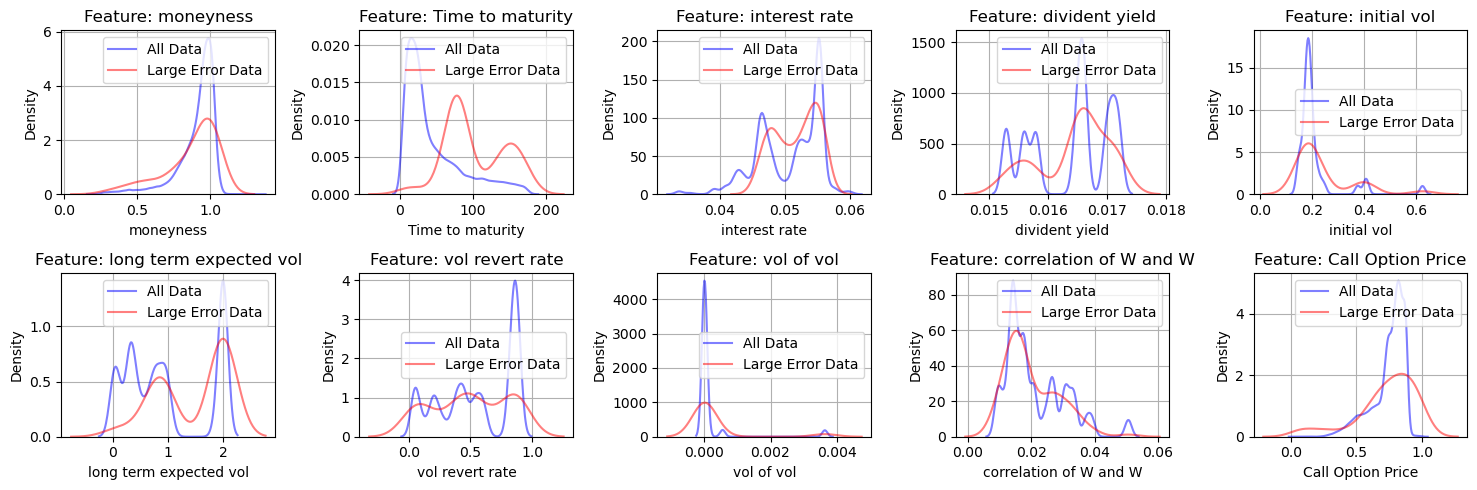

Correlation with Prediction Error:
moneyness                -0.039757
Time to maturity          0.130178
interest rate             0.014517
divident yield            0.016629
initial vol               0.050041
long term expected vol    0.021939
vol revert rate          -0.049194
vol of vol                0.007757
correlation of W and W    0.003210
Call Option Price        -0.148625
dtype: float64


In [8]:
# Define hyperparameter search space for GradientBoostingRegressor
def gradient_boosting_param_space(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 1300, 2100, step=200),
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'random_state': 10
    }

from sklearn.ensemble import GradientBoostingRegressor

# Initialize the trainer for GradientBoostingRegressor
trainer_gb = ModelTrainer(GradientBoostingRegressor, gradient_boosting_param_space, X_train, y_train)

# Optimize hyperparameters
trainer_gb.optimize(n_trials=10)

# Train and make predictions
gb_y_pred = trainer_gb.predict(X_test)

# Evaluate results
trainer_gb.result_evaluation(X_test, y_test, gb_y_pred)


## Tune XGBoost with Optuna (n estimators, max depth, learning rate)

[I 2024-12-09 21:56:34,138] A new study created in memory with name: no-name-9fc4e20b-7e20-47b0-9a79-b70e5798c390


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-12-09 21:56:43,001] Trial 0 finished with value: 0.01416254874192066 and parameters: {'n_estimators': 1900, 'max_depth': 7, 'learning_rate': 0.06112726861658336}. Best is trial 0 with value: 0.01416254874192066.
[I 2024-12-09 21:56:47,823] Trial 1 finished with value: 0.014621942707827261 and parameters: {'n_estimators': 1300, 'max_depth': 5, 'learning_rate': 0.29373205818051396}. Best is trial 0 with value: 0.01416254874192066.
[I 2024-12-09 21:56:50,896] Trial 2 finished with value: 0.015794147694550995 and parameters: {'n_estimators': 1900, 'max_depth': 7, 'learning_rate': 0.29673119897902134}. Best is trial 0 with value: 0.01416254874192066.
[I 2024-12-09 21:57:03,789] Trial 3 finished with value: 0.014595682465358726 and parameters: {'n_estimators': 2100, 'max_depth': 7, 'learning_rate': 0.013147175580781422}. Best is trial 0 with value: 0.01416254874192066.
[I 2024-12-09 21:57:09,087] Trial 4 finished with value: 0.015203326125679584 and parameters: {'n_estimators': 1500,

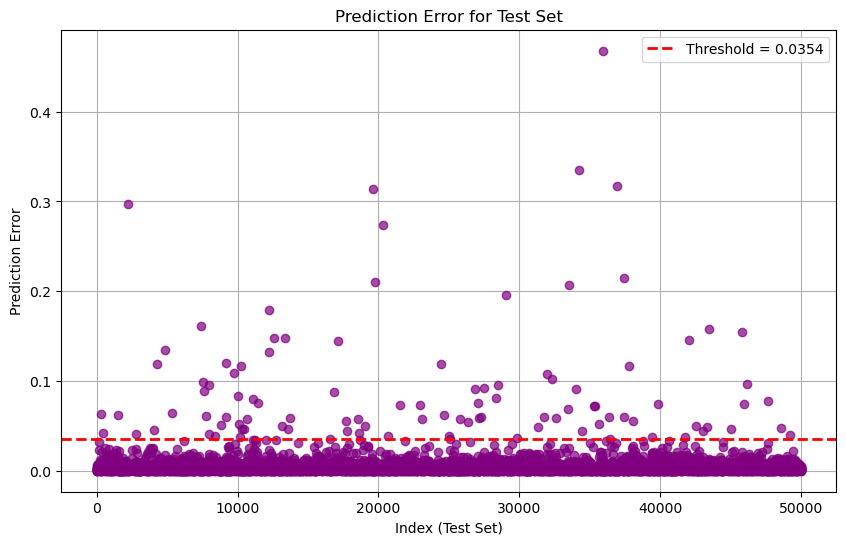

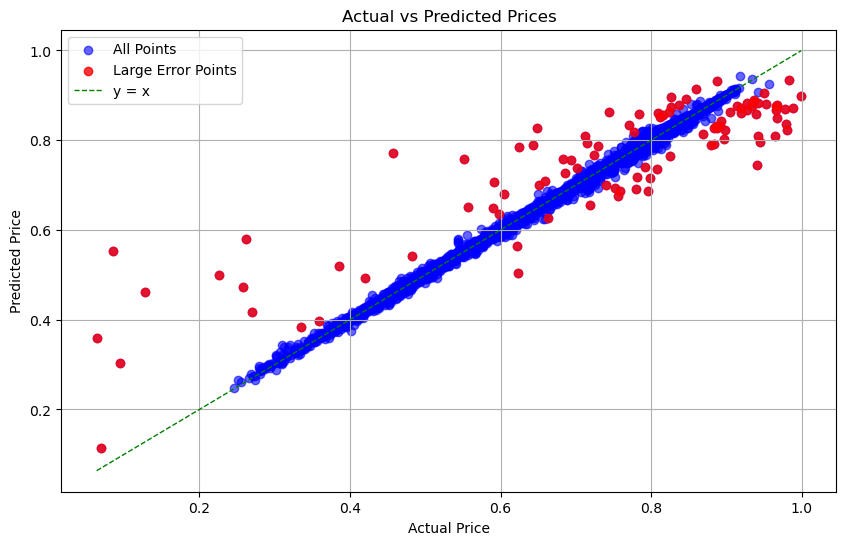

Feature Means Comparison:
                        All Data Mean  Large Error Data Mean
moneyness                    0.905414               0.864828
Time to maturity            44.927257              99.166400
interest rate                0.050728               0.051205
divident yield               0.016384               0.016511
initial vol                  0.212124               0.234888
long term expected vol       0.969919               1.495349
vol revert rate              0.549986               0.493379
vol of vol                   0.000172               0.000178
correlation of W and W       0.021241               0.020538
Call Option Price            0.747589               0.734277


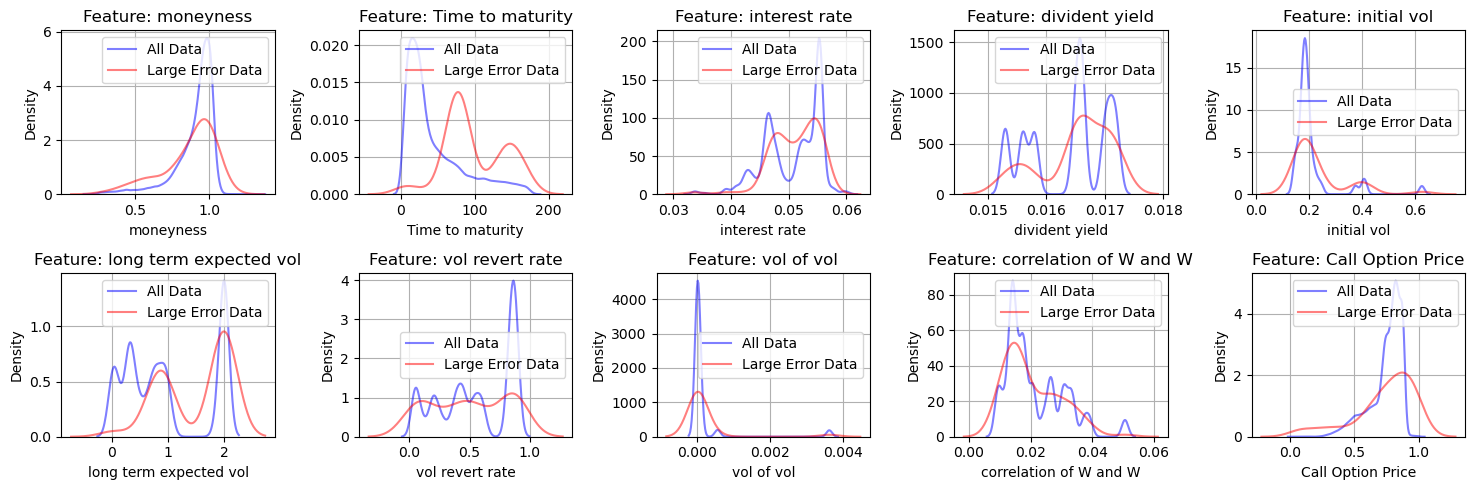

Correlation with Prediction Error:
moneyness                -0.059576
Time to maturity          0.130506
interest rate             0.005620
divident yield            0.022723
initial vol               0.062547
long term expected vol    0.001496
vol revert rate          -0.062838
vol of vol                0.008791
correlation of W and W    0.002491
Call Option Price        -0.155918
dtype: float64


In [16]:
# Define hyperparameter search space for XGBoost
def xgboost_param_space(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 1300, 2100, step=200),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        #'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        #'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': 10,
        'n_jobs': -1
    }

from xgboost import XGBRegressor

# Initialize the trainer for XGBoost
trainer_xgb = ModelTrainer(XGBRegressor, xgboost_param_space, X_train, y_train)

# Optimize hyperparameters
trainer_xgb.optimize(n_trials=10)

# Train and make predictions
xgb_y_pred = trainer_xgb.predict(X_test)

# Evaluate results
trainer_xgb.result_evaluation(X_test, y_test, xgb_y_pred)


## Tune CatBoost with Optuna (iterations, depth, learning rate)

[I 2024-12-09 21:57:54,622] A new study created in memory with name: no-name-be20b46f-73e8-4b9f-a6cb-65d0e5ee7d16


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-12-09 21:58:05,715] Trial 0 finished with value: 0.015921498362327556 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.05133507976051298}. Best is trial 0 with value: 0.015921498362327556.
[I 2024-12-09 21:59:28,324] Trial 1 finished with value: 0.013024797764239454 and parameters: {'iterations': 1400, 'depth': 10, 'learning_rate': 0.03592557161802258}. Best is trial 1 with value: 0.013024797764239454.
[I 2024-12-09 21:59:53,337] Trial 2 finished with value: 0.013045347077097159 and parameters: {'iterations': 2000, 'depth': 4, 'learning_rate': 0.2631688503373353}. Best is trial 1 with value: 0.013024797764239454.
[I 2024-12-09 22:00:10,089] Trial 3 finished with value: 0.0179144661728056 and parameters: {'iterations': 1400, 'depth': 3, 'learning_rate': 0.0770255613131815}. Best is trial 1 with value: 0.013024797764239454.
[I 2024-12-09 22:01:14,109] Trial 4 finished with value: 0.012461117151809456 and parameters: {'iterations': 1800, 'depth': 9, 'learning_ra

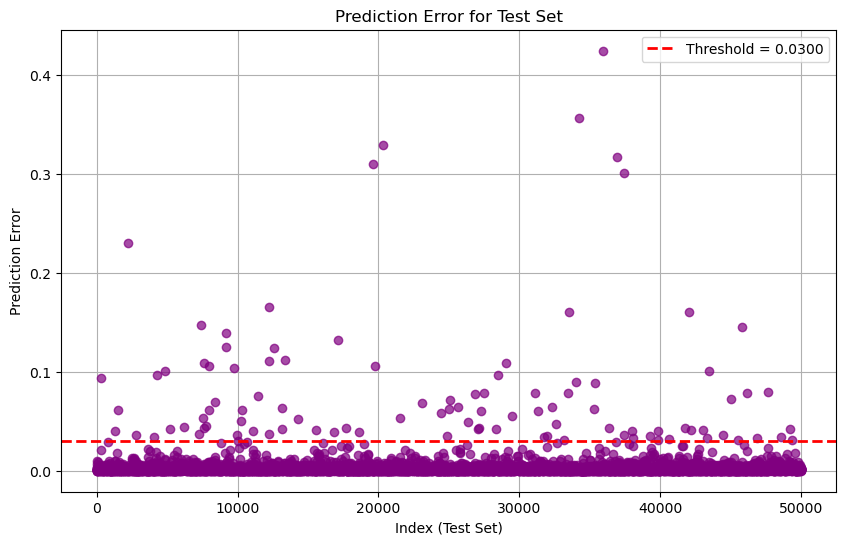

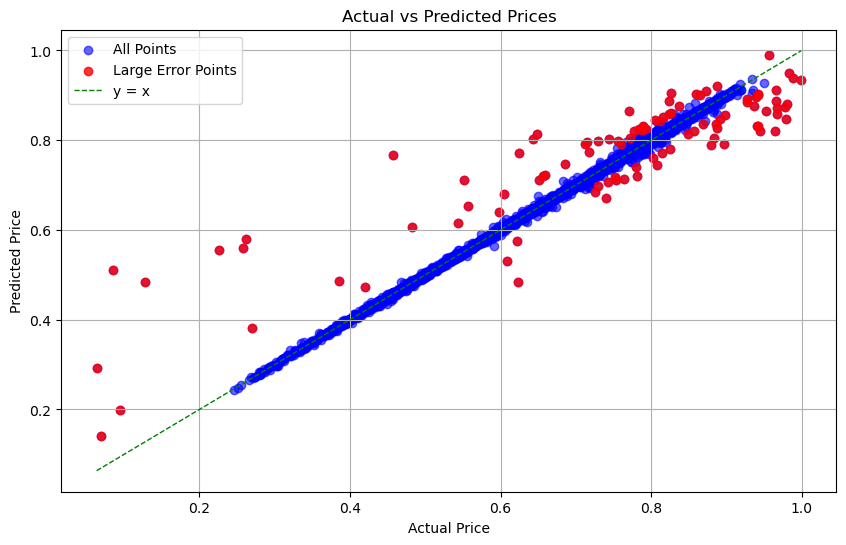

Feature Means Comparison:
                        All Data Mean  Large Error Data Mean
moneyness                    0.905414               0.872757
Time to maturity            44.927257             104.677600
interest rate                0.050728               0.051600
divident yield               0.016384               0.016448
initial vol                  0.212124               0.231704
long term expected vol       0.969919               1.542110
vol revert rate              0.549986               0.517049
vol of vol                   0.000172               0.000251
correlation of W and W       0.021241               0.020631
Call Option Price            0.747589               0.738360


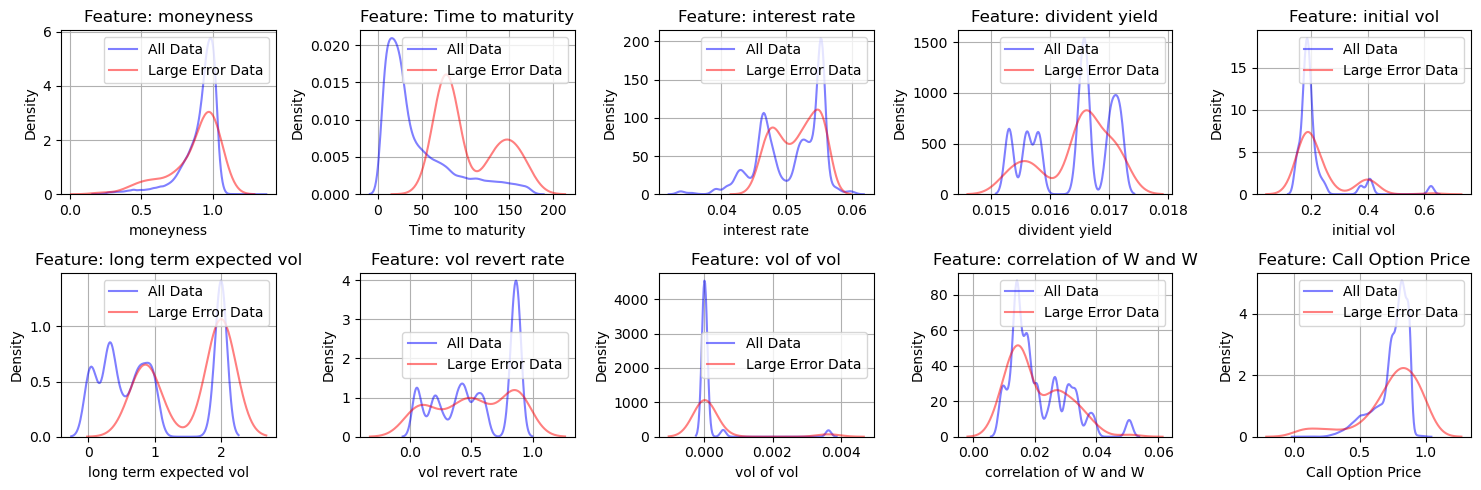

Correlation with Prediction Error:
moneyness                -0.050698
Time to maturity          0.135772
interest rate             0.010371
divident yield            0.018116
initial vol               0.039641
long term expected vol    0.050302
vol revert rate          -0.037089
vol of vol                0.012499
correlation of W and W    0.003160
Call Option Price        -0.105825
dtype: float64


In [17]:
# Define hyperparameter search space for CatBoost
def catboost_param_space(trial):
    return {
        'iterations': trial.suggest_int('iterations', 1000, 2000, step=200),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        #'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        #'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_seed': 10
    }

from catboost import CatBoostRegressor

# Initialize the trainer for CatBoost
trainer_cb = ModelTrainer(CatBoostRegressor, catboost_param_space, X_train, y_train)

# Optimize hyperparameters
trainer_cb.optimize(n_trials=10)

# Train and make predictions
cb_y_pred = trainer_cb.predict(X_test)

# Evaluate results
trainer_cb.result_evaluation(X_test, y_test, cb_y_pred)


## Tune LightGBM with Optuna (num_leaves, n_estimators, max_depth, learning_rate)

[I 2024-12-09 22:06:40,822] A new study created in memory with name: no-name-8c944373-1fc0-4edc-9936-c42fbe945f0a


  0%|          | 0/13 [00:00<?, ?it/s]

[I 2024-12-09 22:06:47,152] Trial 0 finished with value: 0.023890311917061733 and parameters: {'num_leaves': 63, 'n_estimators': 872, 'max_depth': 3, 'learning_rate': 0.015239387889447054}. Best is trial 0 with value: 0.023890311917061733.
[I 2024-12-09 22:06:54,664] Trial 1 finished with value: 0.014941001893965612 and parameters: {'num_leaves': 20, 'n_estimators': 1055, 'max_depth': 10, 'learning_rate': 0.030743250818581445}. Best is trial 1 with value: 0.014941001893965612.
[I 2024-12-09 22:07:04,145] Trial 2 finished with value: 0.014554071633047505 and parameters: {'num_leaves': 66, 'n_estimators': 1462, 'max_depth': 5, 'learning_rate': 0.24962378352811881}. Best is trial 2 with value: 0.014554071633047505.
[I 2024-12-09 22:07:11,466] Trial 3 finished with value: 0.014416588349093122 and parameters: {'num_leaves': 52, 'n_estimators': 877, 'max_depth': 10, 'learning_rate': 0.05519303979256803}. Best is trial 3 with value: 0.014416588349093122.
[I 2024-12-09 22:07:27,736] Trial 4 fi

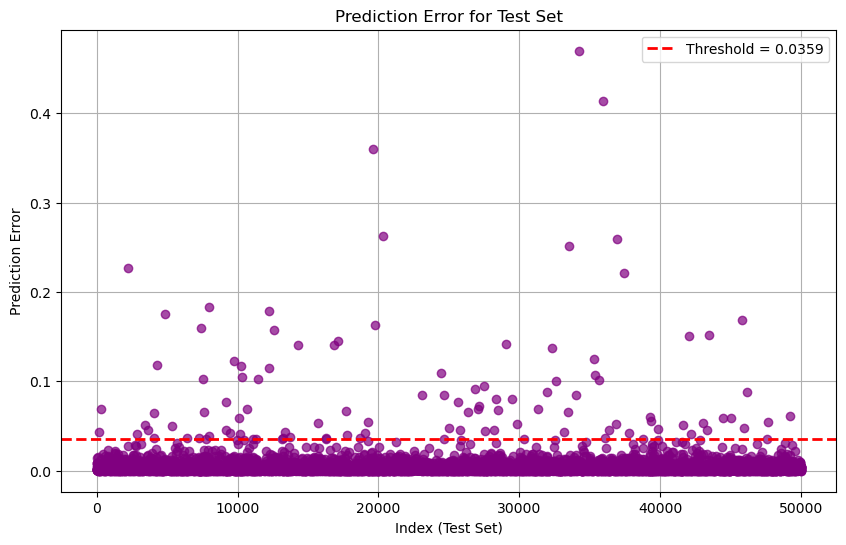

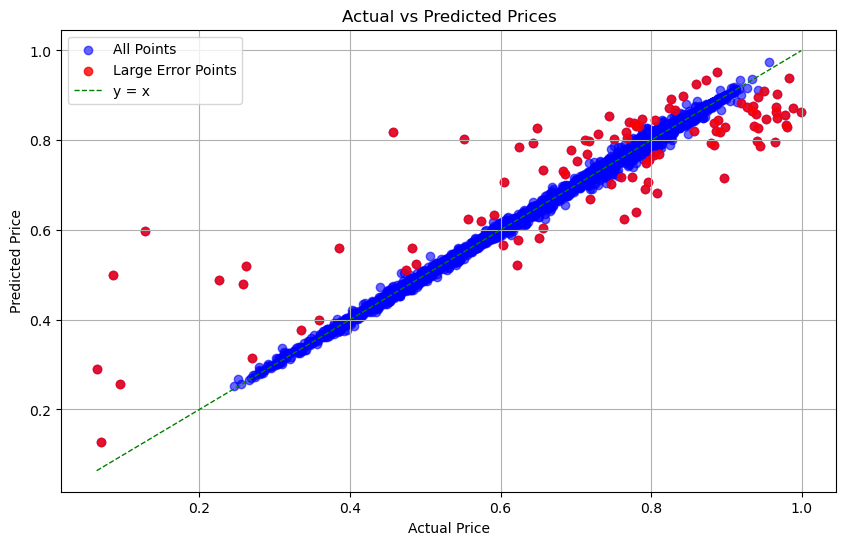

Feature Means Comparison:
                        All Data Mean  Large Error Data Mean
moneyness                    0.905414               0.876065
Time to maturity            44.927257              99.367200
interest rate                0.050728               0.050979
divident yield               0.016384               0.016521
initial vol                  0.212124               0.231790
long term expected vol       0.969919               1.432426
vol revert rate              0.549986               0.516181
vol of vol                   0.000172               0.000206
correlation of W and W       0.021241               0.020389
Call Option Price            0.747589               0.724767


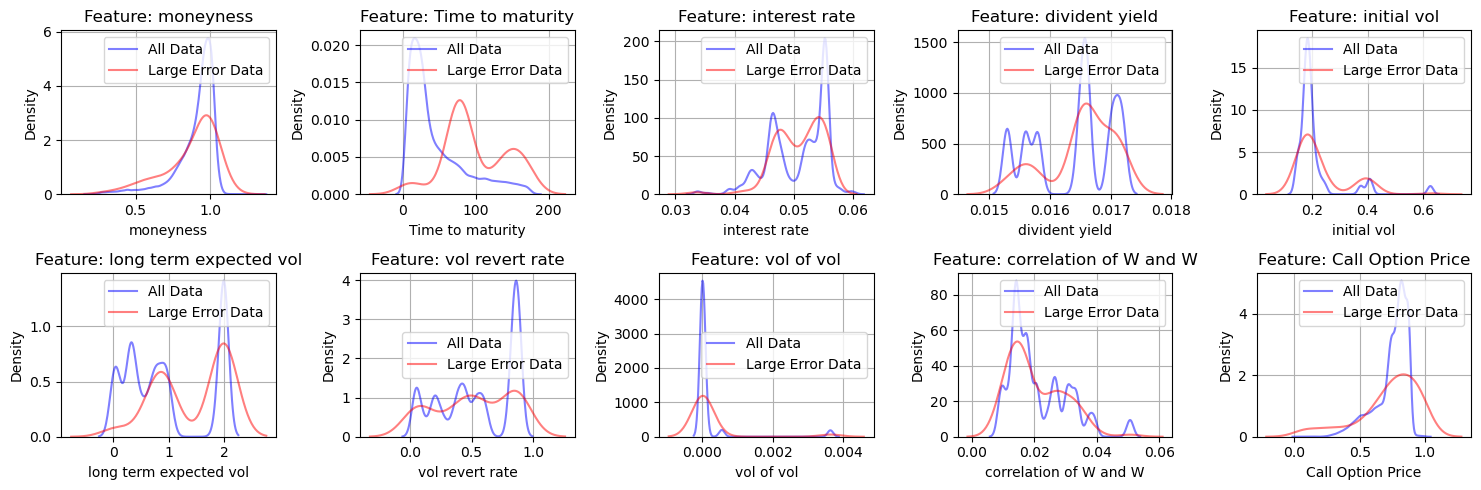

Correlation with Prediction Error:
moneyness                -0.061953
Time to maturity          0.146658
interest rate             0.012422
divident yield            0.016856
initial vol               0.060550
long term expected vol    0.007757
vol revert rate          -0.060433
vol of vol                0.012890
correlation of W and W    0.002720
Call Option Price        -0.131489
dtype: float64


In [18]:
# Define hyperparameter search space for LightGBM
def lightgbm_param_space(trial):
    return {
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'random_state': 10
    }

from lightgbm import LGBMRegressor

# Initialize the trainer for LightGBM
trainer_lgb = ModelTrainer(LGBMRegressor, lightgbm_param_space, X_train, y_train)

# Optimize hyperparameters
trainer_lgb.optimize(n_trials=13)

# Train and make predictions
lgb_y_pred = trainer_lgb.predict(X_test)

# Evaluate results
trainer_lgb.result_evaluation(X_test, y_test, lgb_y_pred)

# Compare time efficiency of the models.